<a href="https://colab.research.google.com/github/Daisuke0209/EM_algorithm/blob/master/190226_EM_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 混合ガウス分布におけるEMアルゴリズムの実装

## ライブラリのインポート

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal as MN
import math

## Google Driveへのマウント

In [474]:
#Google Driveのマウントを取る
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Old Faithful間欠泉データをGitHubから取ってくる

In [475]:
!git clone https://github.com/aidiary/PRML.git

fatal: destination path 'PRML' already exists and is not an empty directory.


## データフレームへの読み込み
Jettin time[min]が間欠泉の噴出時間、Waiting time[min]が次の間欠泉噴出までの待ち時間

In [476]:
df = pd.read_table('/content/PRML/ch9/faithful.txt',delim_whitespace=True)
features=['Jetting time[min]','Waiting time[min]']
df.columns=[features]
df.head()

,Jetting time[min],Waiting time[min]
0,1.800,54.0
1,3.333,74.0
2,2.283,62.0
3,4.533,85.0
4,2.883,55.0


## 散布図の表示
横軸が噴出時間、縦軸が次の噴出までの待ち時間。どうやら二つのグループに分けられそう

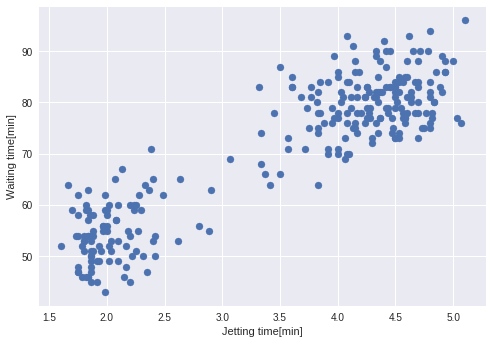

In [477]:
plt.scatter(df[features[0]],df[features[1]])
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

## データの標準化（平均０、分散１に）
データ標準化に加えて、混合ガウス分布の初期値を決定し、散布図に合わせて描画

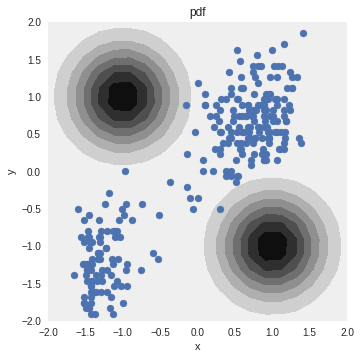

In [485]:
#データの標準化
ss = pre.StandardScaler()
data = ss.fit_transform(df)


X,Y = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))
pos = np.dstack((x,y))

#1つ目のガウス分布
mean1 = np.array([1, -1])
cov1  = 0.2*np.array([[1.0,0.0],[0.0,1.0]])
pi1=0.5
Z1 = pi1*MN(mean1,cov1).pdf(pos)



#2つ目のガウス分布
mean2 = np.array([-1, 1])
cov2  = 0.2*np.array([[1.0,0.0],[0.0,1.0]])
pi2=0.5
Z2 = pi2*MN(mean2,cov2).pdf(pos)

#混合ガウス分布
Z = Z1+Z2

#間欠泉データのプロットと等高線の描画
fig = plt.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.contourf(X,Y,Z,cmap='binary')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('pdf')
ax.scatter(data[:,0],data[:,1])
plt.show()

z=z1+z2をEMアルゴリズムに与える初期の混合ガウス分布とする。
EMアリゴリズムは処理が重いので、一般的には初期分布を求めるために、先にK-meansアルゴリズムを使ったりする。

## EMアルゴリズムの実装
EMアルゴリズムでやっていることは、簡単に言うと対数尤度の最大化を図ろうとしている。
混合ガウス分布の場合、局所解が複数あり、どれに収束するかはやってみないと分からない。

In [0]:
#対数尤度計算
def calc_LH(mean1,mean2,cov1,cov2,pi1,pi2,data):
  LH = 0
  for i in range(len(data)):
    x1=data[i][0]
    x2=data[i][1]
    MN1 = pi1*MN(mean1,cov1).pdf([x1,x2])
    MN2 = pi2*MN(mean2,cov2).pdf([x1,x2])
    LH = LH + math.log(MN1+MN2)
  
  return LH

In [0]:
#Eステップ(負担率計算)
#負担率初期化
def Estep(mean1,mean2,cov1,cov2,pi1,pi2,data):
  gamma1=[0 for i in range(len(data))]
  gamma2=[0 for i in range(len(data))]
  for i in range(len(data)):
    x1=data[i][0]
    x2=data[i][1]
    MN1 = pi1*MN(mean1,cov1).pdf([x1,x2])
    MN2 = pi2*MN(mean2,cov2).pdf([x1,x2])
    gamma1[i]= MN1/(MN1+MN2)
    gamma2[i]= MN2/(MN1+MN2)
  
  return gamma1, gamma2

In [0]:
#Mステップ(現在の負担率を計算し、パラメータ更新)
#Nkの更新
def M_step(gamm1,gamma2,data):
  N1=N2=0
  for i in range(len(data)):
    N1 = N1 + gamma1[i]
    N2 = N2 + gamma2[i]

  #混合係数の更新
  pi1 = N1/len(data)
  pi2 = N2/len(data)

  #平均の更新
  mean1 = np.array([0,0])
  mean2 = np.array([0,0])
  for i in range(len(data)): 
    mean1 = mean1 + gamma1[i]*data[i]/N1
    mean2 = mean2 + gamma2[i]*data[i]/N2

  #分散の更新
  cov1  = np.array([[0.0,0.0],[0.0,0.0]])
  cov2  = np.array([[0.0,0.0],[0.0,0.0]])
  for i in range(len(data)):
    a1 = data[i]-mean1
    a1 = a1.reshape((1,2))
    cov1 = cov1 + np.dot(a1.T,a1)*gamma1[i]/N1
    a2 = data[i]-mean2
    a2 = a2.reshape((1,2))
    cov2 = cov2 + np.dot(a2.T,a2)*gamma2[i]/N2
  return pi1,pi2,mean1,mean2,cov1,cov2

In [486]:
#EMアルゴリズムの実行
LH_pre = 100
LH = 0
N = 0
while abs(LH_pre-LH)>1:
  N = N+1
  LH_pre=LH
  LH = calc_LH(mean1,mean2,cov1,cov2,pi1,pi2,data)
  print(LH)
  gamma1,gamma2=Estep(mean1,mean2,cov1,cov2,pi1,pi2,data)
  pi1,pi2,mean1,mean2,conv1,cov2=M_step(gamma1,gamma2,data)
  
print('EMアルゴリズムは%.d回で収束しました'%N)

-2433.1413680905
-740.153646887109
-525.6521054760293
-498.30044672438044
-486.7967272510528
-479.43134896363637
-473.899306967838
-468.79298091973027
-462.642456535324
-453.2666574059002
-438.2000523966594
-420.95418836321153
-409.5010790278457
-403.97239981504146
-403.6209607027961
EMアルゴリズムは15回で収束しました


# EMアルゴリズム後の推定混合ガウス分布
EMアルゴリズム後、ちゃんと推定できているか確認

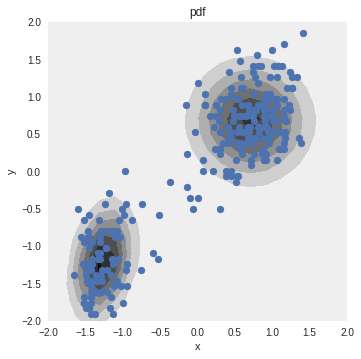

In [488]:
#データの標準化
ss = pre.StandardScaler()
data = ss.fit_transform(df)


X,Y = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))
pos = np.dstack((x,y))

#1つ目のガウス分布
Z1 = pi1*MN(mean1,cov1).pdf(pos)
#2つ目のガウス分布
Z2 = pi2*MN(mean2,cov2).pdf(pos)

#混合ガウス分布
Z = Z1+Z2

#間欠泉データのプロットと等高線の描画
fig = plt.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.contourf(X,Y,Z,cmap='binary')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('pdf')

ax.scatter(data[:,0],data[:,1])

plt.show()

なんか問題無さそう(;´･ω･)